# Analysis of TCGA DNA Methylation Data and Clinical Data

## Data Processing

In [39]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.preprocessing import LabelEncoder
!pwd

/Users/tanishagupta/GRIPS


In [40]:
#pulls raw KIPAN data from local drive and strips away unecessary information
raw_clin_kipan = pd.read_csv('KIPAN.clin.merged.txt', sep='\t', header=None ).T

raw_clin_kipan.columns = raw_clin_kipan.iloc[0]
raw_clin_kipan = raw_clin_kipan[1:]
#raw_clin_kipan

In [41]:
#finds columns with "barcode" in the name. This is essential for finding the correct IDs to match with the methylation data. 
selected_columns = raw_clin_kipan.columns.to_numpy()[raw_clin_kipan.columns.str.contains('barcode')]
#selected_columns = [ i for i in selected_columns if 'drug_barcode' not in i]
selected_columns = [ i for i in selected_columns if '-' not in i]
#selected_columns

In [42]:
#selects only the data with the barcode titled columns
raw_clin_kipan_barcode = raw_clin_kipan.loc[:,selected_columns]
#raw_clin_kipan_barcode

In [43]:
#sets the new column names
raw_clin_kipan_barcode.columns = [s.split('.')[-1] for s in selected_columns]
#raw_clin_kipan_barcode

In [44]:
#drop the barcode columns that are not correct
raw_clin_kipan_barcode.drop(['bcr_drug_barcode','bcr_radiation_barcode',
                             'biospecimen_barcode_bottom','bcr_followup_barcode',
                             'shipment_portion_bcr_aliquot_barcode','bcr_omf_barcode'], 
                            axis=1, errors='ignore')

,bcr_patient_barcode,bcr_sample_barcode,bcr_aliquot_barcode,bcr_analyte_barcode,bcr_portion_barcode,bcr_slide_barcode
1,tcga-kl-8328,tcga-kl-8328-01a,tcga-kl-8328-01a-11d-2308-01,tcga-kl-8328-01a-11d,tcga-kl-8328-01a-11,tcga-kl-8328-01a-01-bs1
2,tcga-kl-8339,tcga-kl-8339-01a,tcga-kl-8339-01a-11d-2308-01,tcga-kl-8339-01a-11d,tcga-kl-8339-01a-11,tcga-kl-8339-01a-01-bs1
3,tcga-km-8439,tcga-km-8439-01a,tcga-km-8439-01a-11d-2308-01,tcga-km-8439-01a-11d,tcga-km-8439-01a-11,tcga-km-8439-01a-01-ts1
4,tcga-km-8441,tcga-km-8441-01a,tcga-km-8441-01a-11d-2308-01,tcga-km-8441-01a-11d,tcga-km-8441-01a-11,tcga-km-8441-01a-01-ts1
5,tcga-km-8442,tcga-km-8442-01a,tcga-km-8442-01a-11d-2308-01,tcga-km-8442-01a-11d,tcga-km-8442-01a-11,tcga-km-8442-01a-01-ts1
...,...,...,...,...,...,...
937,tcga-y8-a896,tcga-y8-a896-01a,tcga-y8-a896-01a-11d-a35y-01,tcga-y8-a896-01a-11d,tcga-y8-a896-01a-11,tcga-y8-a896-01a-01-ts1
938,tcga-y8-a897,tcga-y8-a897-01a,tcga-y8-a897-01a-11d-a35y-01,tcga-y8-a897-01a-11d,tcga-y8-a897-01a-11,tcga-y8-a897-01a-01-ts1
939,tcga-y8-a8ry,tcga-y8-a8ry-01a,tcga-y8-a8ry-01a-11d-a36w-01,tcga-y8-a8ry-01a-11d,tcga-y8-a8ry-01a-11,tcga-y8-a8ry-01a-01-ts1
940,tcga-y8-a8s0,tcga-y8-a8s0-01a,tcga-y8-a8s0-01a-11d-a36w-01,tcga-y8-a8s0-01a-11d,tcga-y8-a8s0-01a-11,tcga-y8-a8s0-01a-01-ts1


In [45]:
# vital_status: The survival state of the person registered on the protocol.
# days_to_death: Number of days between the date used for index and the date from a person's date of death represented as a calculated number of days.

tcga_id_kipan='patient.samples.sample.portions.portion.analytes.analyte.aliquots.aliquot.bcr_aliquot_barcode'

clin_kipan = raw_clin_kipan.loc[:,[tcga_id_kipan, 'admin.disease_code',
'patient.days_to_death','patient.vital_status', 
'patient.age_at_initial_pathologic_diagnosis', 'patient.gender', 'patient.follow_ups.follow_up.person_neoplasm_cancer_status', 
                                  'patient.stage_event.pathologic_stage']]
                                #, 'patient.karnofsky_performance_score']]

#clin_kipan

In [46]:
#set appropriate index for the data table. Sort indexes
clin_kipan = clin_kipan.set_index(tcga_id_kipan)
clin_kipan.index = clin_kipan.index.str.upper()
clin_kipan.sort_index(inplace=True)

In [47]:
#clin_kipan.columns

In [48]:
clin_kipan = clin_kipan[clin_kipan.index.notnull()]

clin_kipan.index = ['-'.join( s.split('-')[:4] ) for s in clin_kipan.index.tolist() ]
#clin_kipan.index

In [49]:
#rename appropriate columns
clin_kipan.rename(columns = {'patient.days_to_death':'days_to_death', 'patient.vital_status':'vital_status', 'patient.age_at_initial_pathologic_diagnosis':'age_at_initial_pathologic_diagnosis', 'patient.gender':'gender', 'admin.disease_code':'subtype', 'patient.follow_ups.follow_up.person_neoplasm_cancer_status':'metastasis_info', 'patient.stage_event.pathologic_stage':'stage'}, inplace = True)

In [50]:
#convert days to death values to floats
vals = clin_kipan['days_to_death'].astype(np.float32)

#create lts and non-lts variable for survival
#current long term survival is two years
clin_kipan['survival'] = 'non-lts'
clin_kipan.loc[pd.to_numeric(clin_kipan.days_to_death).ge(5*365) | clin_kipan.days_to_death.isna(), 'survival'] = 'lts'
#clin_kipan

In [51]:
#read in raw METHYLATION data
meth_kipan = pd.read_csv('KIPAN.hm450.tsv', delim_whitespace=True, header=[0] ).set_index('Composite_Element_REF').drop(['Gene_Symbol','Chromosome','Genomic_Coordinate'], axis=1 ).T

In [52]:
#sort methylation data by index
meth_kipan.sort_index().head()

Composite_Element_REF,cg00000029,cg00000108,cg00000109,cg00000165,cg00000236,cg00000289,cg00000292,cg00000321,cg00000363,cg00000622,...,cg09560636,cg09560650,cg09560658,cg09560723,cg09560763,cg09560811,cg09560911,cg09560912,cg09560953,cg09560979
TCGA-2K-A9WE-01A-11D-A383-05,0.461441,NaN,NaN,0.143910,0.847165,0.737362,0.716795,0.351877,0.248987,0.012136,...,NaN,NaN,0.929777,NaN,0.821841,0.927202,0.018890,NaN,0.844136,NaN
TCGA-2Z-A9J1-01A-11D-A383-05,0.595894,NaN,NaN,0.080724,0.867306,0.706806,0.217862,0.169408,0.173115,0.010890,...,NaN,NaN,0.684141,NaN,0.287309,0.932596,0.018205,NaN,0.253988,NaN
TCGA-2Z-A9J2-01A-11D-A383-05,0.481305,NaN,NaN,0.437447,0.898927,0.758109,0.868605,0.577745,0.567242,0.012268,...,NaN,NaN,0.934065,NaN,0.393975,0.949127,0.027293,NaN,0.898587,NaN
TCGA-2Z-A9J3-01A-12D-A383-05,0.553850,NaN,NaN,0.064233,0.917291,0.675538,0.543087,0.850444,0.470811,0.012568,...,NaN,NaN,0.939414,NaN,0.198644,0.944607,0.019058,NaN,0.648340,NaN
TCGA-2Z-A9J5-01A-21D-A383-05,0.184349,NaN,NaN,0.126119,0.928018,0.677846,0.850474,0.444735,0.204529,0.012233,...,NaN,NaN,0.926087,NaN,0.589858,0.931093,0.029658,NaN,0.722906,NaN


## Determining overlap between methylation and clinical data 

In [53]:
len( set(meth_kipan.index) )

867

In [54]:
len ( set( [ '-'.join( i.split('-')[:4] ) for i in meth_kipan.index ] ) )

867

In [55]:
meth_kipan.index = [ '-'.join( i.split('-')[:4] ) for i in meth_kipan.index ]
meth_kipan.sort_index(inplace=True)
#meth_kipan

In [56]:
len( set( clin_kipan.index ) & set( meth_kipan.index ) )

660

In [57]:
len( set( clin_kipan.index ) - set( meth_kipan.index ) )

281

In [58]:
len( set( meth_kipan.index ) - set( clin_kipan.index ) )

207

In [59]:
#set( meth_kipan.index ) - set( clin_kipan.index )

In [60]:
#determine the number of type of TCGA ID
from collections import Counter

Counter( [i.split('-')[3] for i in meth_kipan.index] )

Counter({'01A': 656, '11A': 205, '01B': 4, '05A': 2})

In [61]:
Counter( [i.split('-')[3] for i in np.array( set( clin_kipan.index ) & set( meth_kipan.index ) ).tolist()])

Counter({'01A': 656, '01B': 4})

In [62]:
#drop these two because they're not matched anywhere
meth_kipan.drop( ['TCGA-DV-A4W0-05A','TCGA-UZ-A9PS-05A'], axis=0, inplace=True, errors = 'ignore')
#meth_kipan

In [63]:
#create a df for normal
clin_normal = pd.DataFrame( index = meth_kipan.index[meth_kipan.index.str.contains('11A')], columns = clin_kipan.columns )
#clin_normal

In [64]:
#set subtype to normal
clin_normal['subtype'] = 'Normal'
#clin_normal

In [65]:
#set kipan values to RCC for all clin_kipan data
clin_kipan['kipan'] = 'RCC'
#clin_kipan

In [66]:
clin_normal['kipan'] = 'Normal'
clin_normal['survival'] = 'Normal'
#clin_normal

In [67]:
#create a df with all normal and tumor values for clinical data
clin_all = pd.concat( [clin_normal, clin_kipan], axis=0 )
clin_all.sort_index( inplace = True )

In [68]:
#clin_all['kipan']

In [69]:
#rename the columns
clin_all = clin_all[['kipan','subtype', 'days_to_death', 'vital_status','survival',
       'age_at_initial_pathologic_diagnosis', 'gender', 'metastasis_info', 'stage']]
#clin_all

## Merging of Two Datasets: clinical and methylation

In [70]:
#final merged df
df_clin_meth = pd.concat([clin_all, meth_kipan], axis='columns', join='inner').sort_values(['kipan'], axis=0)
#df_clin_meth

In [71]:
#determine number of each subtype, very useful for future calcs
Counter( df_clin_meth['subtype'] )

Counter({'Normal': 205, 'kirp': 275, 'kirc': 319, 'kich': 66})

In [72]:
#transpose merged df for ease of use
#df_clin_meth = df_clin_meth.T

In [73]:
#df_clin_meth.head(10)

# Long Term and Short Term Survival LR:

Steps:

    1. Create a seperate data frame for the tumor samples only 
    2. Strip data of nan values.
    3. Onehot encode survival variable
    4. Train model
    5. Validate with 5-fold cross validation
    6. Test model and display confusion matrix/ROC curve

In [74]:
df_temp = df_clin_meth.iloc[205:,:].dropna(axis=1)

In [75]:
df_temp.head(10)

,kipan,subtype,vital_status,survival,gender,cg00000029,cg00000165,cg00000236,cg00000289,cg00000292,...,cg09560465,cg09560533,cg09560549,cg09560590,cg09560599,cg09560658,cg09560763,cg09560811,cg09560911,cg09560953
TCGA-DW-7837-01A,RCC,kirp,alive,lts,male,0.376769,0.133514,0.920249,0.758389,0.366383,...,0.920778,0.916277,0.548739,0.585431,0.033874,0.928231,0.476170,0.914799,0.021657,0.791100
TCGA-DW-7838-01A,RCC,kirp,alive,lts,male,0.428999,0.323824,0.848638,0.658495,0.756420,...,0.933386,0.860630,0.665402,0.426442,0.028878,0.937400,0.591879,0.941179,0.034291,0.786955
TCGA-CZ-5470-01A,RCC,kirc,alive,lts,female,0.691030,0.417824,0.834346,0.832776,0.356401,...,0.934555,0.795048,0.797864,0.526280,0.019556,0.958347,0.434283,0.953972,0.023925,0.831902
TCGA-CZ-5468-01A,RCC,kirc,dead,non-lts,male,0.344641,0.515318,0.929271,0.839432,0.733833,...,0.795183,0.524840,0.780188,0.518742,0.012885,0.938761,0.505760,0.967286,0.025050,0.818742
TCGA-CZ-5469-01A,RCC,kirc,dead,non-lts,male,0.292792,0.237511,0.927863,0.845145,0.850905,...,0.948674,0.575097,0.863986,0.744172,0.011540,0.947662,0.201551,0.947919,0.015485,0.893338
TCGA-CZ-5467-01A,RCC,kirc,dead,non-lts,female,0.515102,0.210351,0.904300,0.744689,0.306671,...,0.948164,0.769161,0.840058,0.613973,0.011737,0.933586,0.402251,0.948508,0.023125,0.718455
TCGA-DW-7836-01A,RCC,kirp,alive,lts,male,0.139762,0.110489,0.927333,0.688138,0.465292,...,0.941845,0.930525,0.754571,0.816807,0.038237,0.943424,0.195248,0.935343,0.028163,0.670649
TCGA-CZ-5464-01A,RCC,kirc,alive,lts,male,0.383120,0.344627,0.786563,0.796758,0.377520,...,0.950205,0.798843,0.496902,0.388252,0.016383,0.950060,0.514802,0.943457,0.018360,0.767545
TCGA-CZ-5986-01A,RCC,kirc,alive,lts,male,0.477054,0.096119,0.916913,0.741369,0.816757,...,0.937418,0.864640,0.597951,0.487986,0.023619,0.933883,0.401095,0.946133,0.030143,0.862010
TCGA-CZ-5984-01A,RCC,kirc,alive,lts,male,0.716020,0.135600,0.926175,0.660109,0.431671,...,0.931605,0.718983,0.736090,0.574325,0.028899,0.945800,0.490957,0.912699,0.025894,0.639126


In [76]:
listy = df_temp["survival"].tolist()

In [77]:
labels = []
for i in range(0, len(listy)):
    if(listy[i] == "lts"):
        labels.append(1)
    else:
        labels.append(0)

In [78]:
df_temp["survival_encoded"] = labels

In [79]:
#do i need to find special diff methylated...if i do i will actually die on a hill bro
X = df_temp.loc[:, ['cg06607764', 'cg00713400', 'cg07355189','cg06330323','cg00716257','cg07600533','cg00849267','cg04972436','cg06474225','cg02578087','cg02952295','cg01890836','cg05343811','cg07093324','cg03063658','cg02326386',]].dropna(axis=1) # Features
y = labels # Target variable

In [93]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [88]:
# 5 folds selected
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
model = LogisticRegression(solver='liblinear')
results = cross_val_score(model, X, y, cv=kfold)
print(results)
# Output the accuracy. Calculate the mean and std across all folds. 
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.78787879 0.81818182 0.87121212 0.81060606 0.79545455]
Accuracy: 81.667% (2.930%)


/var/folders/6s/sfty3wm96t51l6m9spnzj7qm0000gq/T/ipykernel_56590/4158861583.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/6s/sfty3wm96t51l6m9spnzj7qm0000gq/T/ipykernel_56590/4158861583.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/6s/sfty3wm96t51l6m9spnzj7qm0000gq/T/ipykernel_56590/4158861583.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/6s/sfty3wm96t51l6m9spnzj7qm0000gq/T/ipykernel_56590/4158861583.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/6s/sfty3wm96t51l6m9spnzj7qm0000gq/T/ipykernel_56590/415

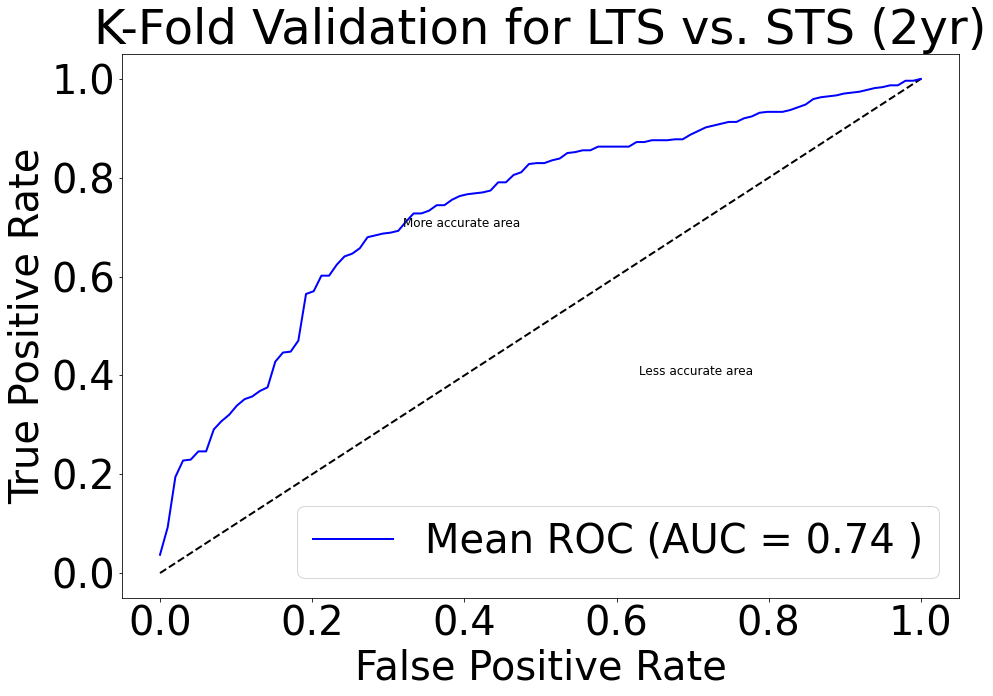

In [96]:
from sklearn.metrics import roc_curve,auc
from scipy import interp
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in kfold.split(X,y):
    prediction = model.fit(X,y).predict_proba(X)
    fpr, tpr, t = roc_curve(y, prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
#figure parameters
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams.update({'font.size': 40})
bins = np.linspace(0, 100, 50)

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation for LTS vs. STS (2yr)')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

#change the legend to match

In [90]:
#X

In [94]:
test_size = 0.5
seed = 0

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
random_state=seed)

model2 = LogisticRegression(solver='liblinear')
model2.fit(X_train, y_train)

predicted = model2.predict(X_test)
matrix = confusion_matrix(y_test, predicted)
print(matrix)
report = classification_report(y_test, predicted)
print(report)

[[  0  62]
 [  0 268]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.81      1.00      0.90       268

    accuracy                           0.81       330
   macro avg       0.41      0.50      0.45       330
weighted avg       0.66      0.81      0.73       330



/Users/tanishagupta/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tanishagupta/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tanishagupta/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

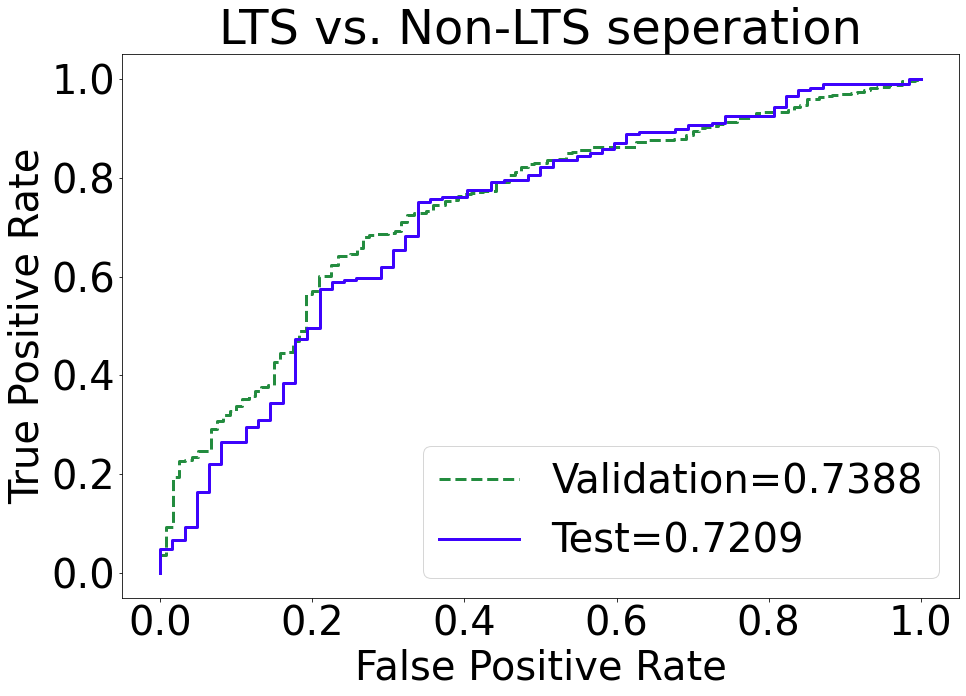

In [97]:
#define metrics

y_pred_proba = model2.predict_proba(X_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="Validation="+str(round(roc_auc, 4)),color="#238C3F", linewidth=3, linestyle='dashed')
plt.plot(fpr2,tpr2,label="Test="+str(round(auc2, 4)),color="#3D03FC", linewidth=3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title("LTS vs. Non-LTS seperation")
plt.show()